# 전처리
- 가격데이터, 반입량데이터 합치기

In [1]:
import os
import pandas as pd

# 파일 경로
cabbage_path = 'data/CabbagePrice.xlsx'
intake_path = 'data/CabbageIntake.xlsx'

# 시트 불러오기
cabbage_df = pd.read_excel(cabbage_path, sheet_name=0)
intake_df = pd.read_excel(intake_path, sheet_name=0)

# 특, 상 필터
grade_ratio = {
    '특': ('Special', 0.05),
    '상': ('HIGH', 0.35),
}
filtered = cabbage_df[cabbage_df['등급명'].isin(grade_ratio)].copy()

# 평균가격 정수형 변환
filtered['avg_price'] = filtered['평균가격'].astype(str).str.replace(',', '').astype(int)

# 0원인 데이터 제거
filtered = filtered[filtered['avg_price'] != 0]

# 레이블, 비율 컬럼 추가
filtered['rate'] = filtered['등급명'].map(lambda x: grade_ratio[x][0])
filtered['비율'] = filtered['등급명'].map(lambda x: grade_ratio[x][1])

# 반입량 합치기
intake_df = intake_df[['DATE', '총반입량']].copy()
intake_df.rename(columns={'총반입량': 'total_intake'}, inplace=True)

merged = pd.merge(filtered, intake_df, on='DATE', how='inner')

# intake 계산
merged['intake'] = (merged['total_intake'] * merged['비율']).round().astype(int)

# 날짜 분해
merged[['year', 'month', 'day']] = merged['DATE'].astype(str).str.split('-', expand=True).astype(int)

# gap 계산 (같은 등급 기준 전날과의 가격 차이)
merged.sort_values(['rate', 'DATE'], inplace=True)
merged['gap'] = merged.groupby('rate')['avg_price'].diff().fillna(0).astype(int)

# 최종 정리
final_df = merged[['year', 'month', 'day', 'intake', 'avg_price', 'gap', 'rate']]
final_df = final_df.sort_values(['year', 'month', 'day', 'rate'])

# 저장
os.makedirs('store', exist_ok=True)
output_path = 'store/cabbage_separated.csv'
final_df.to_csv(output_path, index=False)

print(final_df.head())

      year  month  day  intake  avg_price  gap     rate
5733  2016      1    4     222       5163    0     HIGH
5732  2016      1    4      32       5716    0  Special
5731  2016      1    5     149       4683 -480     HIGH
5730  2016      1    5      21       5180 -536  Special
5729  2016      1    6     127       4722   39     HIGH


# 배추, 상

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

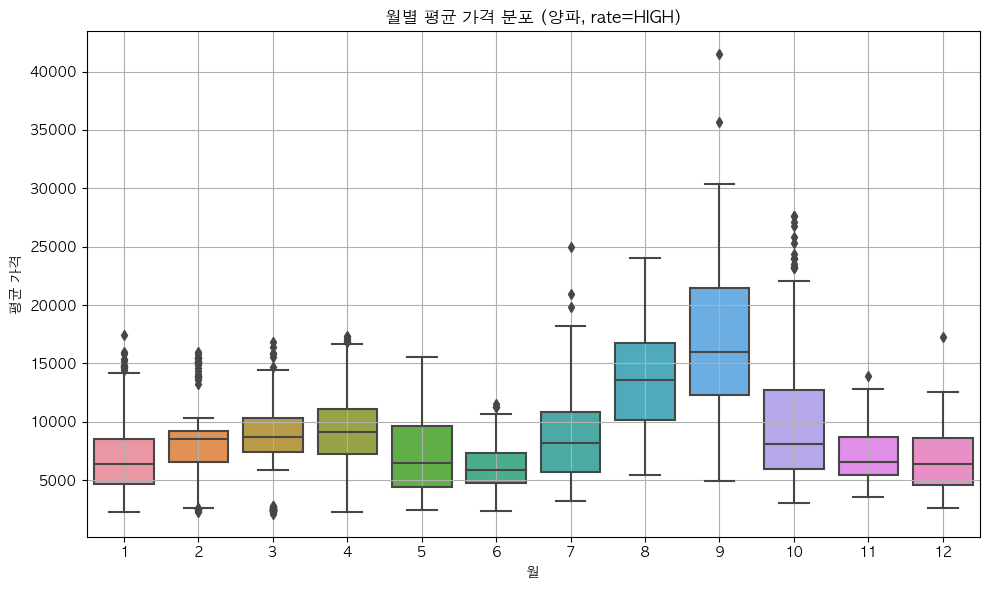

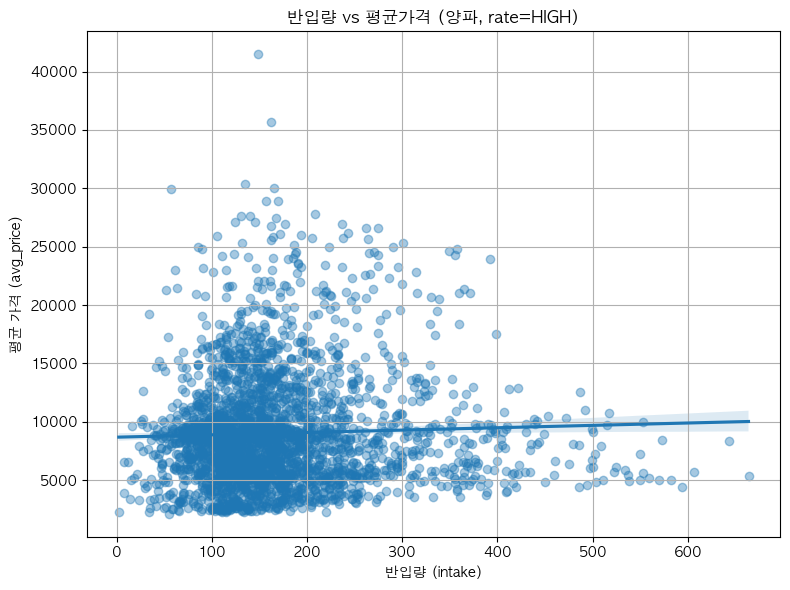

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 양파 데이터 불러오기
onion_df = pd.read_csv("store/cabbage_separated.csv")

# 'rate'가 'HIGH'인 데이터
high_df = onion_df[onion_df['rate'] == 'HIGH']

# 1번: 월별 평균 가격 분산 분석 (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=high_df, x='month', y='avg_price')
plt.title('월별 평균 가격 분포 (양파, rate=HIGH)')
plt.xlabel('월')
plt.ylabel('평균 가격')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2번: 평균 가격과 반입량(intake)의 상관관계 (산점도 + 회귀선)
plt.figure(figsize=(8, 6))
sns.regplot(data=high_df, x='intake', y='avg_price', scatter_kws={"alpha":0.4})
plt.title('반입량 vs 평균가격 (양파, rate=HIGH)')
plt.xlabel('반입량 (intake)')
plt.ylabel('평균 가격 (avg_price)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5번: 가격 급등/급락 시점 탐지 (gap 기준 상하위 5%)
gap_sorted = high_df.copy()
gap_sorted['abs_gap'] = gap_sorted['gap'].abs()
threshold = gap_sorted['abs_gap'].quantile(0.95)
extreme_gap_df = gap_sorted[gap_sorted['abs_gap'] >= threshold]




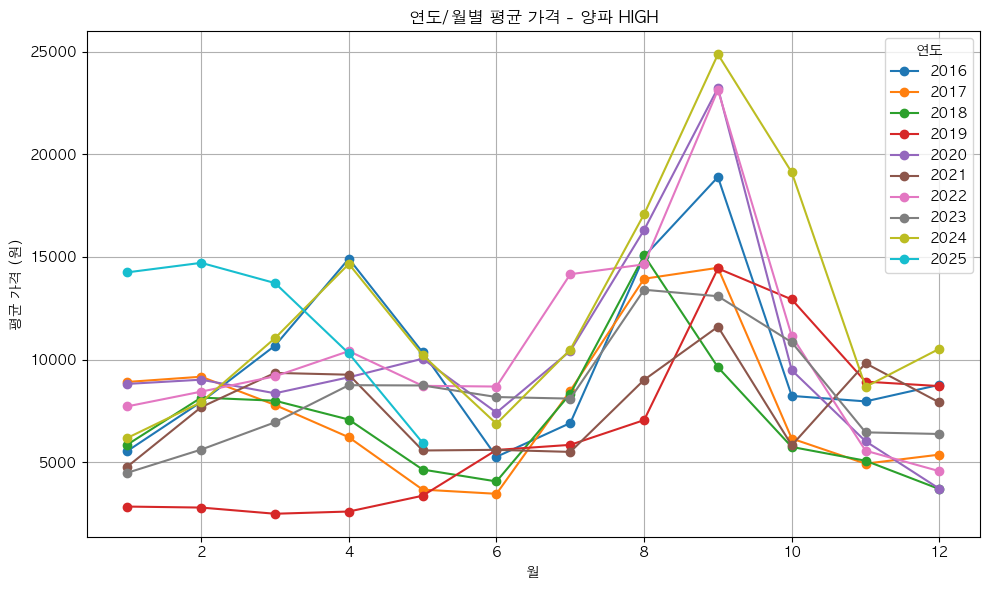

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 양파 HIGH 데이터 불러오기
onion_df = pd.read_csv("store/cabbage_separated.csv")
high_df = onion_df[onion_df['rate'] == 'HIGH']

# 연도/월별 평균 가격 계산
grouped_high = high_df.groupby(['year', 'month'])['avg_price'].mean().reset_index()

# 피벗 테이블 생성
pivot_high = grouped_high.pivot(index='month', columns='year', values='avg_price')

# 시각화
plt.figure(figsize=(10, 6))
for year in pivot_high.columns:
    plt.plot(pivot_high.index, pivot_high[year], label=str(year), marker='o')
plt.title('연도/월별 평균 가격 - 양파 HIGH')
plt.xlabel('월')
plt.ylabel('평균 가격 (원)')
plt.legend(title='연도')
plt.grid(True)
plt.tight_layout()
plt.show()


#

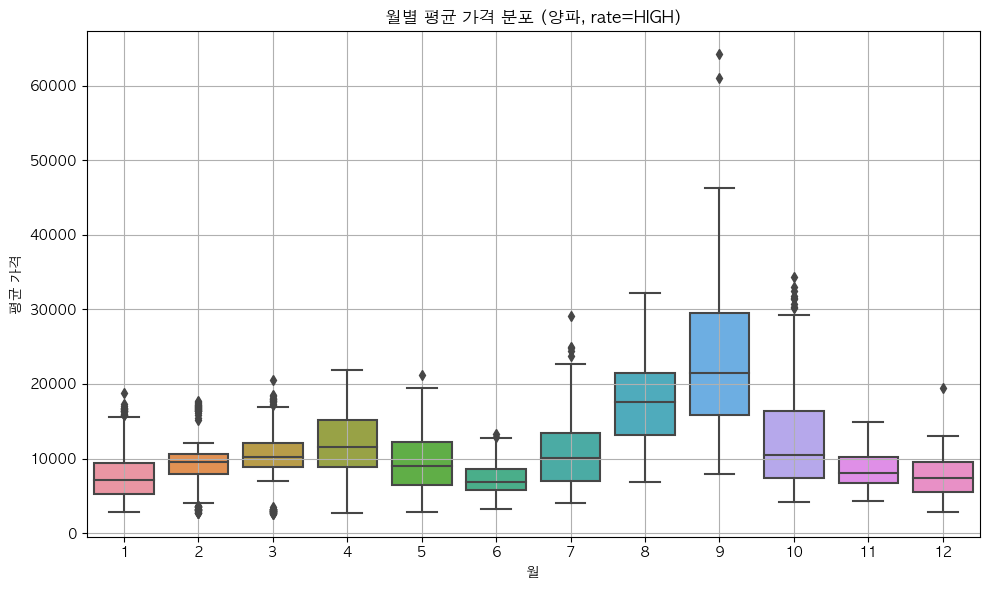

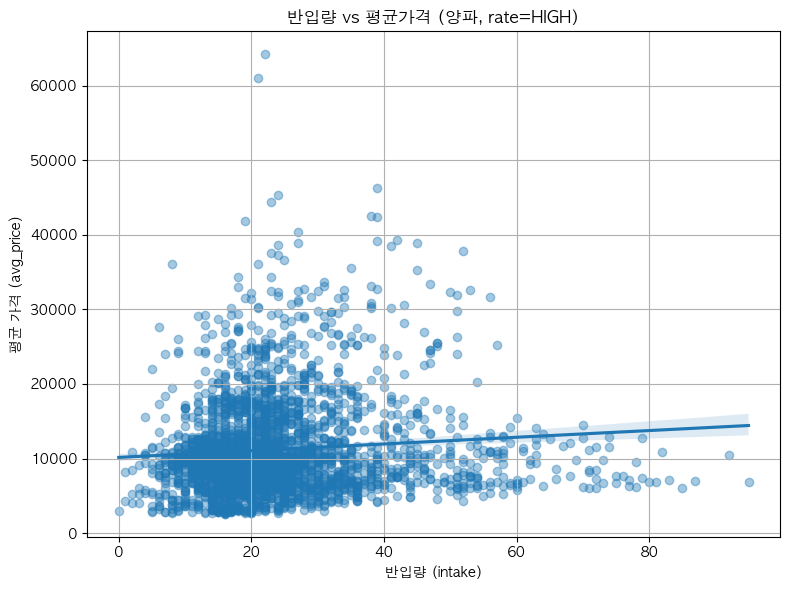

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 양파 데이터 불러오기
onion_df = pd.read_csv("store/cabbage_separated.csv")

# 'rate'가 'HIGH'인 데이터
high_df = onion_df[onion_df['rate'] == 'Special']

# 1번: 월별 평균 가격 분산 분석 (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(data=high_df, x='month', y='avg_price')
plt.title('월별 평균 가격 분포 (양파, rate=HIGH)')
plt.xlabel('월')
plt.ylabel('평균 가격')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2번: 평균 가격과 반입량(intake)의 상관관계 (산점도 + 회귀선)
plt.figure(figsize=(8, 6))
sns.regplot(data=high_df, x='intake', y='avg_price', scatter_kws={"alpha":0.4})
plt.title('반입량 vs 평균가격 (양파, rate=HIGH)')
plt.xlabel('반입량 (intake)')
plt.ylabel('평균 가격 (avg_price)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5번: 가격 급등/급락 시점 탐지 (gap 기준 상하위 5%)
gap_sorted = high_df.copy()
gap_sorted['abs_gap'] = gap_sorted['gap'].abs()
threshold = gap_sorted['abs_gap'].quantile(0.95)
extreme_gap_df = gap_sorted[gap_sorted['abs_gap'] >= threshold]




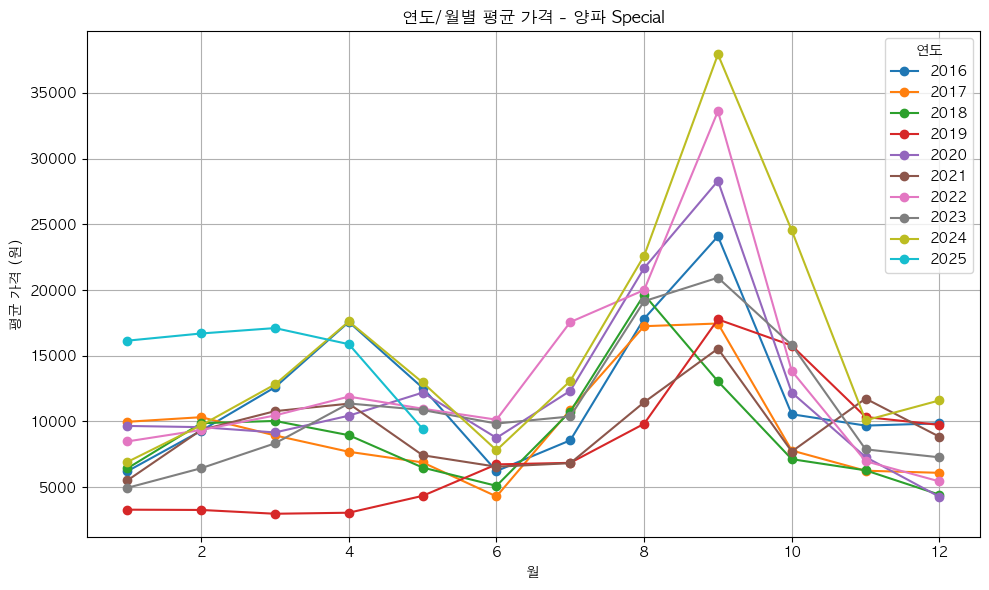

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 양파 HIGH 데이터 불러오기
onion_df = pd.read_csv("store/cabbage_separated.csv")
high_df = onion_df[onion_df['rate'] == 'Special']

# 연도/월별 평균 가격 계산
grouped_high = high_df.groupby(['year', 'month'])['avg_price'].mean().reset_index()

# 피벗 테이블 생성
pivot_high = grouped_high.pivot(index='month', columns='year', values='avg_price')

# 시각화
plt.figure(figsize=(10, 6))
for year in pivot_high.columns:
    plt.plot(pivot_high.index, pivot_high[year], label=str(year), marker='o')
plt.title('연도/월별 평균 가격 - 양파 Special')
plt.xlabel('월')
plt.ylabel('평균 가격 (원)')
plt.legend(title='연도')
plt.grid(True)
plt.tight_layout()
plt.show()


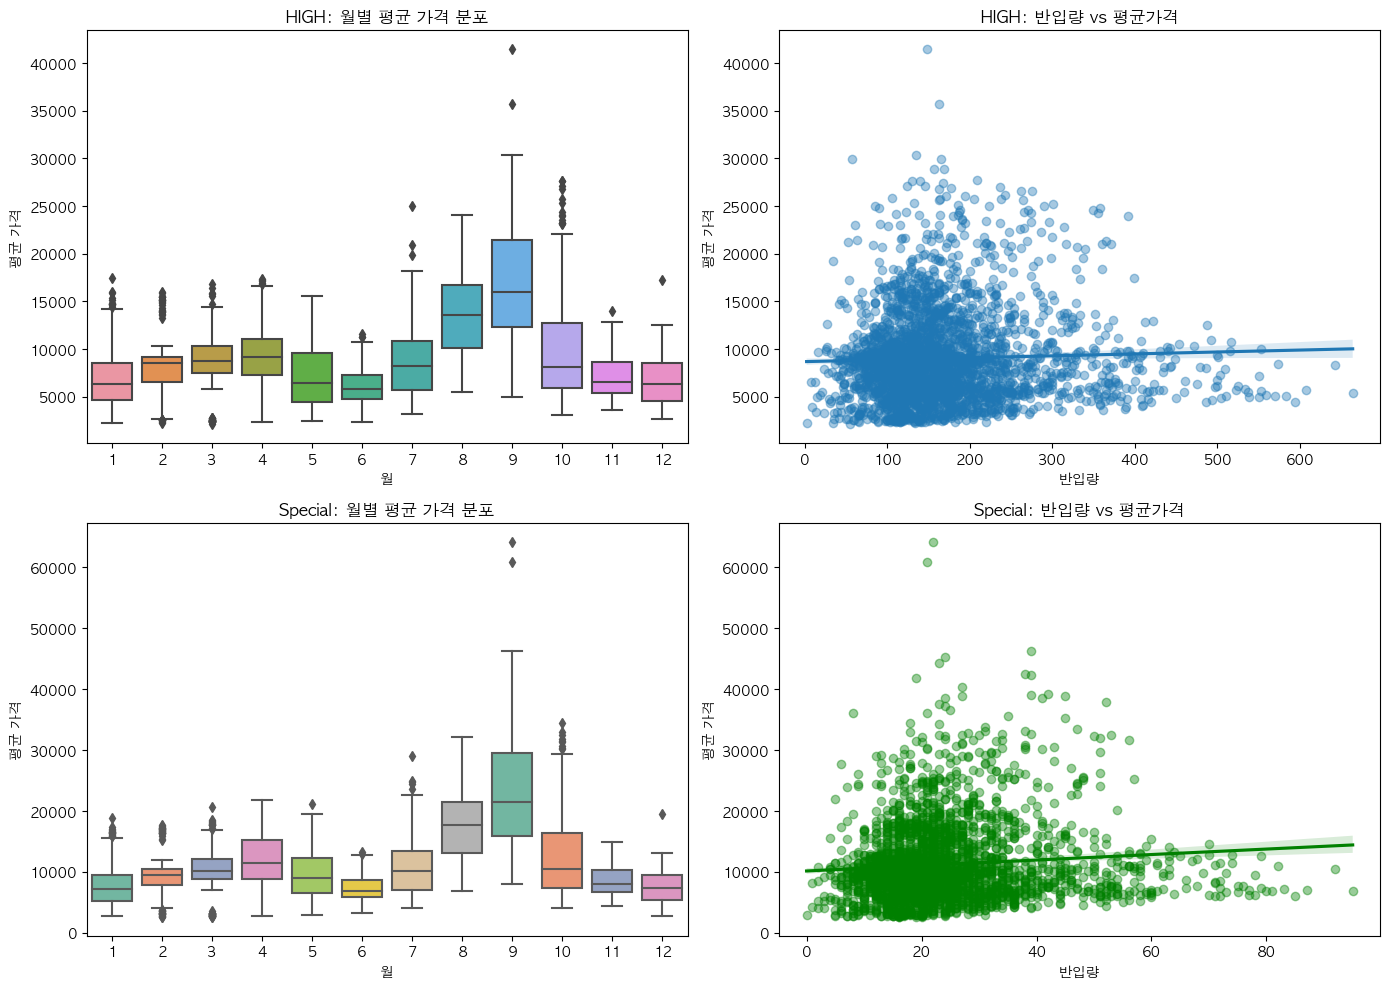

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
onion_df = pd.read_csv("store/cabbage_separated.csv")
high_df = onion_df[onion_df['rate'] == 'HIGH']
special_df = onion_df[onion_df['rate'] == 'Special']

# 그래프 그리기
plt.figure(figsize=(14, 10))

# 1번: HIGH - Boxplot
plt.subplot(2, 2, 1)
sns.boxplot(data=high_df, x='month', y='avg_price')
plt.title('HIGH: 월별 평균 가격 분포')
plt.xlabel('월')
plt.ylabel('평균 가격')

# 2번: HIGH - intake vs avg_price
plt.subplot(2, 2, 2)
sns.regplot(data=high_df, x='intake', y='avg_price', scatter_kws={"alpha": 0.4})
plt.title('HIGH: 반입량 vs 평균가격')
plt.xlabel('반입량')
plt.ylabel('평균 가격')

# 3번: SPECIAL - Boxplot
plt.subplot(2, 2, 3)
sns.boxplot(data=special_df, x='month', y='avg_price', palette='Set2')
plt.title('Special: 월별 평균 가격 분포')
plt.xlabel('월')
plt.ylabel('평균 가격')

# 4번: SPECIAL - intake vs avg_price
plt.subplot(2, 2, 4)
sns.regplot(data=special_df, x='intake', y='avg_price', color='green', scatter_kws={"alpha": 0.4})
plt.title('Special: 반입량 vs 평균가격')
plt.xlabel('반입량')
plt.ylabel('평균 가격')

# 전체 show
plt.tight_layout()
plt.show()


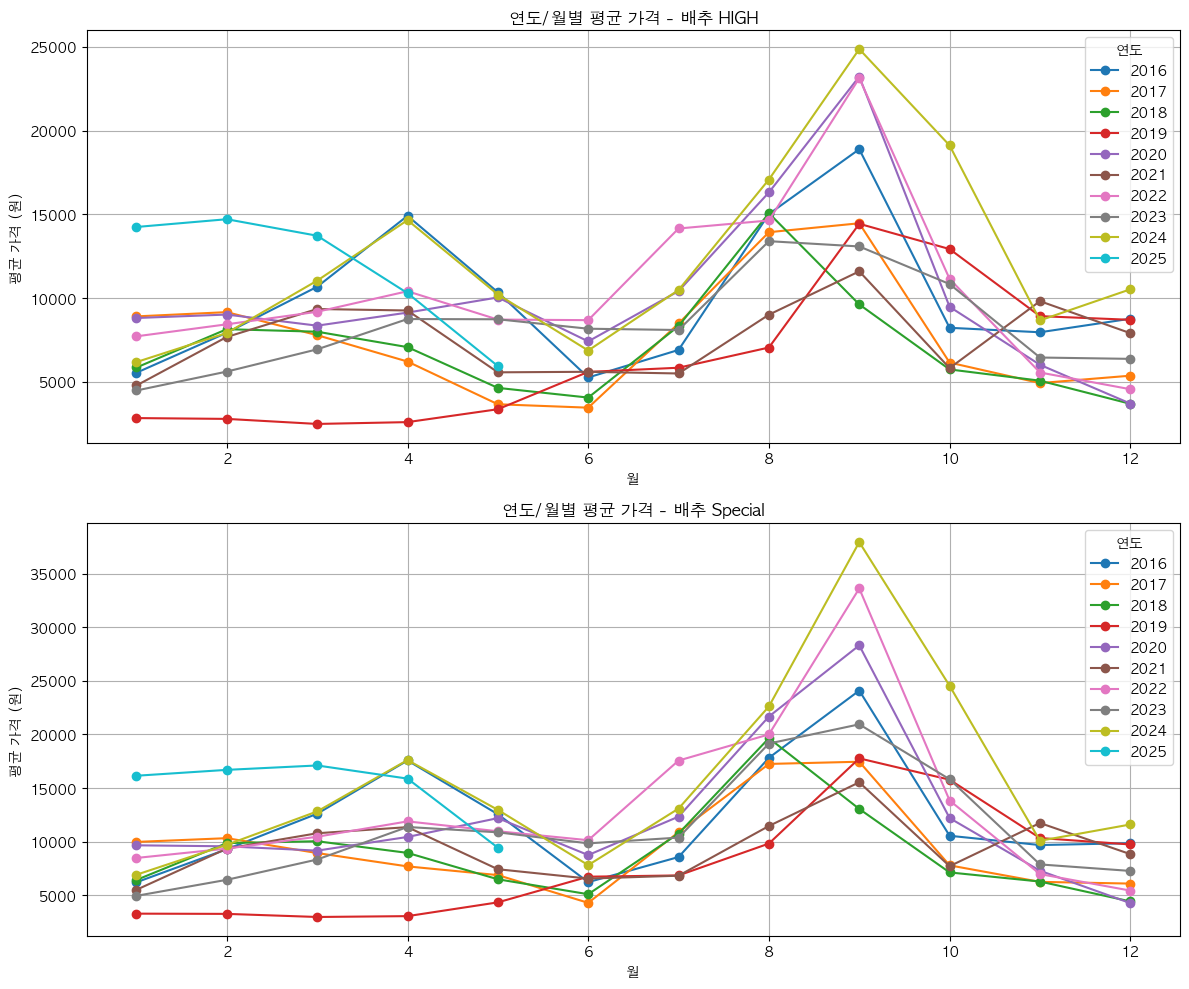

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 양파 데이터 불러오기
onion_df = pd.read_csv("store/cabbage_separated.csv")

# HIGH 데이터 처리
high_df = onion_df[onion_df['rate'] == 'HIGH']
grouped_high = high_df.groupby(['year', 'month'])['avg_price'].mean().reset_index()
pivot_high = grouped_high.pivot(index='month', columns='year', values='avg_price')

# Special 데이터 처리
special_df = onion_df[onion_df['rate'] == 'Special']
grouped_special = special_df.groupby(['year', 'month'])['avg_price'].mean().reset_index()
pivot_special = grouped_special.pivot(index='month', columns='year', values='avg_price')

# 그래프 출력
plt.figure(figsize=(12, 10))

# HIGH 그래프
plt.subplot(2, 1, 1)
for year in pivot_high.columns:
    plt.plot(pivot_high.index, pivot_high[year], label=str(year), marker='o')
plt.title('연도/월별 평균 가격 - 배추 HIGH')
plt.xlabel('월')
plt.ylabel('평균 가격 (원)')
plt.legend(title='연도')
plt.grid(True)

# Special 그래프
plt.subplot(2, 1, 2)
for year in pivot_special.columns:
    plt.plot(pivot_special.index, pivot_special[year], label=str(year), marker='o')
plt.title('연도/월별 평균 가격 - 배추 Special')
plt.xlabel('월')
plt.ylabel('평균 가격 (원)')
plt.legend(title='연도')
plt.grid(True)

plt.tight_layout()
plt.show()
